In [138]:
!pip install xgboost

  Using cached xgboost-1.5.2-py3-none-win_amd64.whl (106.6 MB)


### Imports

In [139]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
%matplotlib inline
from sklearn.metrics import mean_squared_error
from suntime import Sun
import pytz

### Helper Fuctions

In [12]:
def datetime_index(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    dataframe['Datetime'] = pd.to_datetime(dataframe['DateTime'])
    dataframe = dataframe.set_index(['Datetime'])
    del dataframe['DateTime']
    return dataframe

def fill_na(dataframe):
    dataframe['WWCode'] = dataframe['WWCode'].fillna(0).astype(int)
    return dataframe

def day_night(dataframe):

    coordinates = [40.239, 33.029] # Ankara
    dataframe['datetime_col'] = dataframe.index
    
    dataframe["Date"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.date.apply(str)
    dataframe["Hour"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.hour
    
    sun = Sun(coordinates[0], coordinates[1])
    tz =pytz.timezone('Europe/Istanbul')
    dataframe["Day"]= dataframe[["Date","Hour"]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).
                                         hour <= x["Hour"] <= sun.get_local_sunset_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).hour ,axis=1)
    dataframe = dataframe.drop(['Date', 'datetime_col', 'Hour'], axis = 1)
    return dataframe

### Reading and Preprocessing

In [13]:
submission = datetime_index(pd.read_csv('sample_submission.csv'))
label = datetime_index(pd.read_csv('generation.csv', delimiter=';', decimal=','))
features = datetime_index(pd.read_csv('temperature.csv', delimiter=';', decimal=','))

In [27]:
x_train  = fill_na(features.loc['2019-01-01':'2021-11-30'])
x_test = day_night(fill_na(features.loc['2021-12-01':'2021-12-31']))
y_train  = label.loc['2019-01-01':'2021-11-30']
y_test = day_night(submission)

In [100]:
df_train = day_night(pd.concat([ x_train, y_train], axis=1))
df_train['Day'][(df_train['Day'] == True) & (df_train['Generation'] == 0)] =False
# df_train = df_train[df_train['Day'] == True].drop(['Day'], axis=1)

C:\Users\asus\AppData\Local\Temp/ipykernel_9916/2601426617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Day'][(df_train['Day'] == True) & (df_train['Generation'] == 0)] =False


In [101]:
set(x_test["WWCode"]) - set(x_train["WWCode"])

{84}

In [102]:
df_train['WWCode'] = df_train['WWCode'].replace([84], 83)

In [116]:
for index, row in df_train.iterrows():
    if row['WWCode'] < 10:
        df_train.loc[index, 'WWCode'] = 1
    elif row['WWCode'] < 20:
        df_train.loc[index, 'WWCode'] = 2
    elif row['WWCode'] < 30:
        df_train.loc[index, 'WWCode'] = 3
    elif row['WWCode'] < 40:
        df_train.loc[index, 'WWCode'] = 4
    elif row['WWCode'] < 50:
        df_train.loc[index, 'WWCode'] = 5
    elif row['WWCode'] < 60:
        df_train.loc[index, 'WWCode'] = 6
    elif row['WWCode'] < 70:
        df_train.loc[index, 'WWCode'] = 7
    elif row['WWCode'] < 80:
        df_train.loc[index, 'WWCode'] = 8
    elif row['WWCode'] < 90:
        df_train.loc[index, 'WWCode'] = 9
    elif row['WWCode'] < 100:
        df_train.loc[index, 'WWCode'] = 10

In [103]:
# df_train['Generation'][(df_train['Day'] == False) & (df_train['WWCode'] == 0) ]
# df_train = df_train[~(df_train['WWCode'] == 0)]

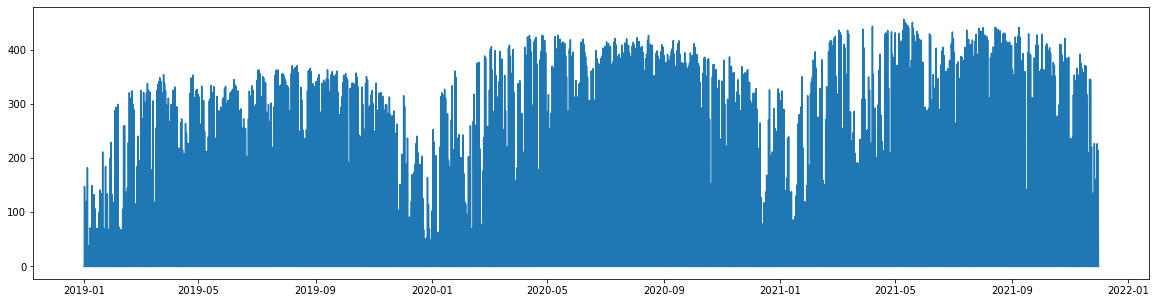

In [104]:
plt.figure(figsize=(20,5))
plt.plot(df_train['Generation'])

In [125]:
df_train = pd.get_dummies(df_train, columns = ['WWCode'])

### Exploring Data

In [126]:
df_train.head()

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Generation,Day,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,WWCode_10
Datetime,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,6.3,0.000000,False,0,1,0,0,0,0,0,0,0
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,4.5,0.000000,False,0,1,0,0,0,0,0,0,0
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,5.5,0.000008,False,0,1,0,0,0,0,0,0,0
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,7.6,0.000000,False,0,1,0,0,0,0,0,0,0
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,6.5,0.000008,False,0,1,0,0,0,0,0,0,0


In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25560 entries, 2019-01-01 00:00:00 to 2021-11-30 23:00:00
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       25560 non-null  float64
 1   ComfortTemperature   25560 non-null  float64
 2   RelativeHumidity     25560 non-null  float64
 3   WindSpeed            25560 non-null  float64
 4   WindDirection        25560 non-null  float64
 5   EffectiveCloudCover  25560 non-null  float64
 6   Generation           25560 non-null  float64
 7   Day                  25560 non-null  bool   
 8   WWCode_1             25560 non-null  uint8  
 9   WWCode_2             25560 non-null  uint8  
 10  WWCode_3             25560 non-null  uint8  
 11  WWCode_5             25560 non-null  uint8  
 12  WWCode_6             25560 non-null  uint8  
 13  WWCode_7             25560 non-null  uint8  
 14  WWCode_8             25560 non-null  uint8  
 15  W

In [108]:
# sns.heatmap(df_train.corr(), cmap="Blues", annot=True);

In [109]:
# sns.pairplot(df_train, aspect=1.5);

### Model Training

In [128]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train.drop(['Generation'], axis = 1), df_train['Generation'], test_size=0.3, random_state=42)

##### Linear Regression

In [130]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, Y_train)

LinearRegression()

In [131]:
score = lin_reg_model.score(X_test,Y_test)
print("r^2 :",score)

r^2 : 0.4817458626316121


In [132]:
pred_val = lin_reg_model.predict(X_test)
pred_val = pd.DataFrame(pred_val, index=X_test.index, columns=['pred'])

In [133]:
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False))

RMSE:  91.02921966605756


##### SGD Regression

In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, Y_train)

In [ ]:
score = sgd_reg.score(X_train, Y_train)
print("R-squared:", score)

In [ ]:
pred_val = sgd_reg.predict(X_test)
pred_val = pd.DataFrame(pred_val, index=X_test.index, columns=['pred'])

In [ ]:
mse = mean_squared_error(Y_test, pred_val, squared=False)
print("RMSE: ", mse**(1/2.0))

##### XGBRegressor

In [140]:
xgb_reg = XGBRegressor(random_state=42,
                     tree_method="gpu_hist",
                     gpu_id=0,predictor="gpu_predictor",
                     n_estimators=5000,)
xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [142]:
score = xgb_reg.score(X_train, Y_train)
print("R-squared:", score)

R-squared: 0.9997624574082202


In [143]:
pred_val = xgb_reg.predict(X_test)
pred_val = pd.DataFrame(pred_val, index=X_test.index, columns=['pred'])

In [146]:
mse = mean_squared_error(Y_test, pred_val, squared=False)
print("RMSE: ", mse)

RMSE:  92.21573417521846


##### Cross_Validation

In [ ]:
cv_score = cross_val_score(sgd_reg, X_test, Y_test, cv = 10)
print("CV mean score: ", cv_score.mean())

In [ ]:
cv_score = cross_val_score(lin_reg_model, X_test, Y_test, cv = 10)
print("CV mean score: ", cv_score.mean())

In [149]:
pd.read_csv('sample_submission.csv')

,DateTime,Generation
0,01Dec2021 0:00:00,0
1,01Dec2021 1:00:00,0
2,01Dec2021 2:00:00,0
3,01Dec2021 3:00:00,0
4,01Dec2021 4:00:00,0
...,...,...
739,31Dec2021 19:00:00,0
740,31Dec2021 20:00:00,0
741,31Dec2021 21:00:00,0
742,31Dec2021 22:00:00,0
